CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8906, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


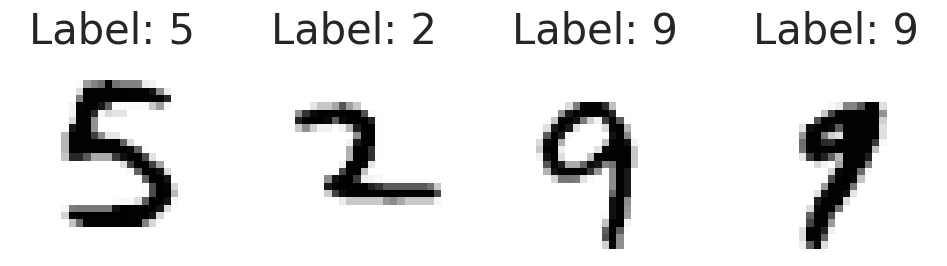

In [1]:
# https://roberttlange.com/posts/2020/03/blog-post-10/
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers


import torch
from torchvision import datasets, transforms
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
key = random.PRNGKey(1)
import time
from helpers import plot_mnist_examples

# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

plot_mnist_examples(train_loader)

In [2]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [3]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)
    
def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))
    
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits) # Note: it is already log scores

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [4]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)

def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

In [5]:
########## This is the core logic that worth understanding ###########################
@jit # note that opt_update is defined later, but jit make it working
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y) # Get value and gradients
    opt_state = opt_update(0, grads, opt_state) # Update optimizer parameters (count steps, adjust acceleration parameters, learning rate, etc)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10

Epoch 1 | T: 8.41 | Train A: 0.974 | Test A: 0.968
Epoch 2 | T: 8.22 | Train A: 0.984 | Test A: 0.975
Epoch 3 | T: 8.26 | Train A: 0.989 | Test A: 0.978
Epoch 4 | T: 8.21 | Train A: 0.993 | Test A: 0.980
Epoch 5 | T: 8.22 | Train A: 0.995 | Test A: 0.980
Epoch 6 | T: 8.25 | Train A: 0.995 | Test A: 0.982
Epoch 7 | T: 8.37 | Train A: 0.997 | Test A: 0.981
Epoch 8 | T: 8.27 | Train A: 0.996 | Test A: 0.981
Epoch 9 | T: 8.24 | Train A: 0.994 | Test A: 0.977
Epoch 10 | T: 8.29 | Train A: 0.997 | Test A: 0.984


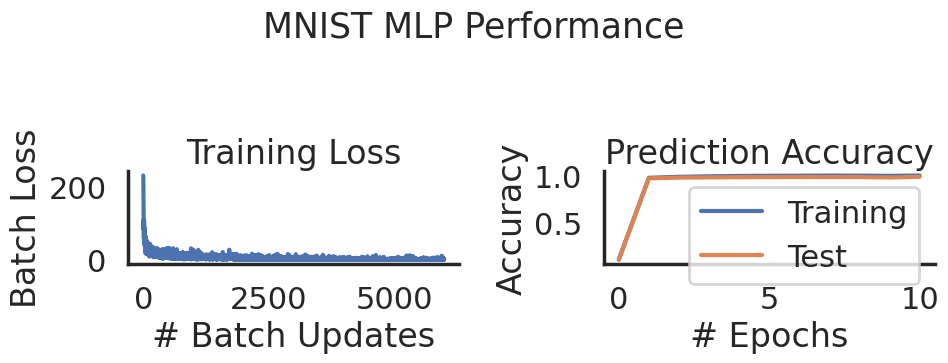

In [6]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

    return train_loss, log_acc_train, log_acc_test


train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")

# Plot the loss curve over time
from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST MLP Performance")